# Compute climate indicators on weather station data from ECCC's API

Environment and Climate Change Canada (ECCC) offers an [API](https://api.weather.gc.ca/collections/climate-daily) to access daily weather station data. This notebook focus is on converting the JSON response from the server to an `xarray.Dataset`. At that point, it's then easy to compute numerous climate indicators on the daily time series using [xclim](http://xclim.readthedocs.io/).

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"  # force use Shapely with GeoPandas

import warnings

import numba

warnings.simplefilter("ignore", category=numba.core.errors.NumbaDeprecationWarning)

import urllib

import cf_xarray as cfxr
import geopandas as gpd
from urlpath import URL

# Compose the request
host = URL("https://api.weather.gc.ca/")
api = host / "collections" / "climate-daily" / "items"
url = api.with_query(
    {
        "datetime": "1840-03-01 00:00:00/2021-06-02 00:00:00",
        "STN_ID": "10761",
        "sortby": "LOCAL_DATE",
    }
)

# Use geopandas to convert the json output to a GeoDataFrame.
with urllib.request.urlopen(url=str(url)) as req:
    gdf = gpd.read_file(filename=req, engine="pyogrio")
gdf.head()

,id,STATION_NAME,CLIMATE_IDENTIFIER,ID,LOCAL_DATE,PROVINCE_CODE,LOCAL_YEAR,LOCAL_MONTH,LOCAL_DAY,MEAN_TEMPERATURE,...,SPEED_MAX_GUST_FLAG,COOLING_DEGREE_DAYS,COOLING_DEGREE_DAYS_FLAG,HEATING_DEGREE_DAYS,HEATING_DEGREE_DAYS_FLAG,MIN_REL_HUMIDITY,MIN_REL_HUMIDITY_FLAG,MAX_REL_HUMIDITY,MAX_REL_HUMIDITY_FLAG,geometry
0,7024745.1994.7.26,MCTAVISH,7024745,7024745.1994.7.26,1994-07-26,QC,1994,7,26,22.0,...,None,4.0,None,0.0,None,NaN,None,NaN,None,POINT (-73.57917 45.50474)
1,7024745.1994.7.27,MCTAVISH,7024745,7024745.1994.7.27,1994-07-27,QC,1994,7,27,19.6,...,None,1.6,None,0.0,None,NaN,None,NaN,None,POINT (-73.57917 45.50474)
2,7024745.1994.7.28,MCTAVISH,7024745,7024745.1994.7.28,1994-07-28,QC,1994,7,28,19.1,...,None,1.1,None,0.0,None,NaN,None,NaN,None,POINT (-73.57917 45.50474)
3,7024745.1994.7.29,MCTAVISH,7024745,7024745.1994.7.29,1994-07-29,QC,1994,7,29,21.7,...,None,3.7,None,0.0,None,NaN,None,NaN,None,POINT (-73.57917 45.50474)
4,7024745.1994.7.30,MCTAVISH,7024745,7024745.1994.7.30,1994-07-30,QC,1994,7,30,20.9,...,None,2.9,None,0.0,None,NaN,None,NaN,None,POINT (-73.57917 45.50474)


The next step is to convert the GeoDataFrame object into an `xarray.Dataset`, to do so, we've created some utilities packaged in `cf-xarray` to convert point geometries (the stations' locations) into CF-compliant coordinates. The function below bundles a number of operations to prepare the data for further analysis.

In [2]:
def preprocessing(gdf):
    """Convert geojson data from the ECCC weather API into a CF-compliant dataset.

    - Rename variables names CF standard names
    - Assign units to variables
    - Mask values with a flag
    - Convert wind directions in tens of degrees to degrees
    - Fill gaps in time series with NaNs

    Parameters
    ----------
    gdf : pandas.GeoDataFrame
      Data from the `api.weather.gc.ca` service.

    Returns
    -------
    xr.Dataset
      Dataset complete with units and CF-compliant temporal and spatial coordinates.

    Notes
    -----
    DIRECTION_MAX_GUST is only reported if the maximum gust speed exceeds 29 km/h.
    A value of 0 or 360 means wind blowing from the geographic north, and 90 from the east.

    """
    import pandas as pd
    import xarray as xr

    # Convert timestamp to datetime object
    gdf["time"] = gdf["LOCAL_DATE"].astype("datetime64[ns]")

    # Drop useless variables
    gdf = gdf.drop(["LOCAL_DATE", "LOCAL_YEAR", "LOCAL_MONTH", "LOCAL_DAY"], axis=1)

    # Convert to xarray.Dataset
    ds = gdf.set_index("time").to_xarray()

    # Convert geometries to CF - creates a features dimension
    ds = cfxr.geometry.reshape_unique_geometries(ds)
    coords = cfxr.shapely_to_cf(ds.geometry, grid_mapping="longitude_latitude")
    coords = coords.drop_vars(["geometry_container", "x", "y"])
    ds = xr.merge([ds.drop_vars("geometry"), coords])

    # Rename `features` dimension to `station`
    ds = ds.rename(features="station")

    # Mask values with a flag then drop flag variable
    for key in ds.data_vars:
        if key.endswith("_FLAG"):
            valid = ds[key].isnull()
            name = key.replace("_FLAG", "")
            ds[name] = ds[name].where(valid)
            ds = ds.drop_vars(key)

    # Convert wind gust from tens of degrees to degrees
    if "DIRECTION_MAX_GUST" in ds.data_vars:
        ds["DIRECTION_MAX_GUST"] *= 10

    # Assign units to variables
    # TODO: Add long_name and description from https://climate.weather.gc.ca/glossary_e.html
    attrs = {
        "MEAN_TEMPERATURE": {
            "units": "degC",
            "standard_name": "air_temperature",
            "cell_methods": "time: mean within days",
        },
        "MIN_TEMPERATURE": {
            "units": "degC",
            "standard_name": "air_temperature",
            "cell_methods": "time: min within days",
        },
        "MAX_TEMPERATURE": {
            "units": "degC",
            "standard_name": "air_temperature",
            "cell_methods": "time: max within days",
        },
        "TOTAL_PRECIPITATION": {
            "units": "mm/day",
            "standard_name": "precipitation_flux",
        },
        "TOTAL_RAIN": {
            "units": "mm/day",
        },
        "TOTAL_SNOW": {"units": "mm/day", "standard_name": "solid_precipitation_flux"},
        "SNOW_ON_GROUND": {"units": "cm", "standard_name": "surface_snow_thickness"},
        "DIRECTION_MAX_GUST": {
            "units": "degree",
            "standard_name": "wind_gust_from_direction",
        },
        "SPEED_MAX_GUST": {
            "units": "km/h",
            "standard_name": "wind_speed_of_gust",
            "cell_methods": "time: max within days",
        },
        "COOLING_DEGREE_DAYS": {"units": "degC days"},
        "HEATING_DEGREE_DAYS": {"units": "degC days"},
        "MIN_REL_HUMIDITY": {
            "units": "%",
            "standard_name": "relative_humidity",
            "cell_methods": "time: min within days",
        },
        "MAX_REL_HUMIDITY": {
            "units": "%",
            "standard_name": "relative_humidity",
            "cell_methods": "time: max within days",
        },
    }

    for key in ds.data_vars:
        ds[key].attrs.update(attrs.get(key, {}))

    # Try to squeeze arrays of identical values along the time dimension
    for key in ["STATION_NAME", "CLIMATE_IDENTIFIER", "PROVINCE_CODE"]:
        ds[key] = squeeze_if_unique(ds[key], "time")

    # Reindex over continuous time series
    ts = pd.date_range(ds.time[0].values, ds.time[-1].values)
    return ds.reindex(time=ts)


def squeeze_if_unique(da, dim):
    """Squeeze dimension out of DataArray if all values are identical or masked.

    If a value is replicated along the time dimension, this function will return a
    DataArray defined only over the dimensions where values vary. If the resulting
    object is a scalar, it is converted to a global attribute.

    Parameters
    ----------
    da : xr.DataArray
      Input values.
    dim : str
      Dimension to squeeze if possible.
    """
    import numpy as np

    def n_unique(arr):
        return len(set(np.unique(arr)) - {""})

    if da.dtype == object:
        # Check if possible to squeeze along `dim`
        n = np.apply_along_axis(
            n_unique,
            da.get_axis_num(dim),
            da.fillna("").values,
        )

        if (n == 1).all():
            return da.max(dim)  # Should avoid returning the null value.

        return da

    # else : int, float or datetime
    da_filled = da.ffill(dim).bfill(dim)
    if (da_filled.isel({dim: 0}) == da_filled).all():
        return da_filled.isel({dim: 0}, drop=True)

    return da

In [3]:
# Conver the GeoDataFrame to an xarray.Dataset
# Different stations are aligned along the `station` dimension
ds = preprocessing(gdf)
ds

<xarray.Dataset>
Dimensions:              (station: 1, time: 1061)
Coordinates:
  * station              (station) int64 0
  * time                 (time) datetime64[ns] 1994-07-26 ... 1997-06-20
    lon                  (station) float64 -73.58
    lat                  (station) float64 45.5
Data variables: (12/18)
    id                   (station, time) object '7024745.1994.7.26' ... '7024...
    STATION_NAME         (station) object 'MCTAVISH'
    CLIMATE_IDENTIFIER   (station) object '7024745'
    ID                   (station, time) object '7024745.1994.7.26' ... '7024...
    PROVINCE_CODE        (station) object 'QC'
    MEAN_TEMPERATURE     (station, time) float64 22.0 19.6 19.1 ... 20.4 20.8
    ...                   ...
    DIRECTION_MAX_GUST   (station, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SPEED_MAX_GUST       (station, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    COOLING_DEGREE_DAYS  (station, time) float64 4.0 1.6 1.1 3.7 ... 0.0 2.4 2.8
    HEATING_DEGREE_DAYS  (station, time) float64 0.0 0.0 0.0 0.0 ... 0.8 0.0 0.0
    MIN_REL_HUMIDITY     (station, time) float64 nan nan nan ... 78.0 38.0 35.0
    MAX_REL_HUMIDITY     (station, time) float64 nan nan nan ... 98.0 99.0 74.0

## Computing climate indicators

In the next cell, we compute the monthly mean temperature from the daily observations. By default, `xclim` is very strict about missing values, marking any month with one missing value as entirely missing. Here we'll use the WMO recommendation for missing data, where a month is considered missing if there are 11 days or more missing, or 5 consecutive missing values.

In [4]:
import xclim

with xclim.set_options(check_missing="wmo"):
    mtas = xclim.atmos.tg_mean(ds.MEAN_TEMPERATURE, freq="MS")

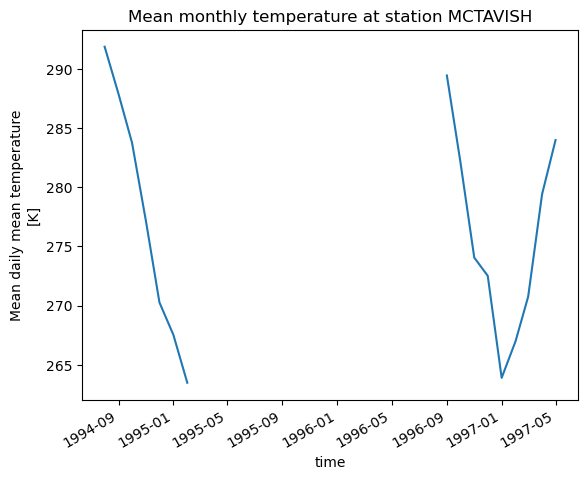

In [5]:
from matplotlib import pyplot as plt

name = ds.STATION_NAME.isel(station=0).values
mtas.isel(station=0).plot()
plt.title(f"Mean monthly temperature at station {name}")
plt.show()